# Extracting Canadian ISPs review data from dslreports.com

### Using BeautifulSoup to extract review data of major Canadian ISPs from dslreports.com
### This is an extension of our work in [this notebook.](https://github.com/C-Youssef/web-scraping-dslreports/blob/main/extracting_Bell_internet_review_data.ipynb)

In [1]:
import os
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import re
# fake_useragent: up to date simple useragent faker with real world database
from fake_useragent import UserAgent
import time
from datetime import date, timedelta
import matplotlib.pyplot as plt
from scraping_review_data import review_data_collection, find_date


## 1. Extracting review data of multiple ISPs

#### In the next cell, we build a function that extracts review data for a given Canadian ISP from dslreports.com and returns the resulting dataset in a DataFrame.

#### We use the function review_data_collection that extracts data from a single web page on dslreport.com. See the local imported module scraping_review_data.

#### We use random user agents to minimize the possibility of our user agent being blocked by the dslreports.com web server. We also add random sleep delays between web requests to emulate the behaviour of a standard user and avoid being blocked by the dslreports.com web server.
            

In [2]:
# Example: URL to access Bell reviews: https://www.dslreports.com/comments/412
service_providers_url_codes = {
'Bell': 412,
'Rogers': 1713,
'Telus': 1623,
'Shaw': 1704,
'TekSavvy': 3626,
'Videotron': 1572,
'Ebox': 2618,
'Cogeco': 1653,  
'Start': 4095 # few reviews
}

def ISP_review_data_extraction(ISP):
    '''
    Extracts review data of a given Canadian ISP from dslreports.com
    arg: ISP: The name of a Canadian ISP
    returns: a DataFrame of review data with the following columns:
    the following columns:
        ['review_by', 'review_id', 'days_or_years_since_review', 'location', 'cost', 
        'installation_time', 'provider', 'pre_sales_information', 'install_co-ordination', 
        'connection_reliability', 'tech_support', 'services', 'value_for_money']
    '''
    # Initialize a list that will hold the DataFrames returned by the function review_data_collection(soup)
    list_reviews_df = []
    
    ua = UserAgent()
    
    pagination_flag = 'next'
    page_number = 1
    print('Extracting page', end='\t')
    while(pagination_flag == 'next'):
        print(page_number, end = '\t')
        url_code = service_providers_url_codes[ISP]
        url = 'https://www.dslreports.com/comments/'+str(url_code)+'?1=1&p=' + str(page_number)
        try:
            # We use random user agents to minimize the possibility of being blocked by 
            # the dslreports.com web server
            response = requests.get(url, timeout = 5,  headers={'user_agent': ua.random})
            response.raise_for_status()
        except requests.exceptions.HTTPError as hte:
            print('HTTP Error:', hte)
            return
        except requests.exceptions.ConnectionError as coe:
            print('Connection error:', coe)
            return
        except requests.exceptions.Timeout as tie:
            print('Timeout error', tie)
            return
        except requests.exceptions.RequestException as ree:
            print('Some other exception error:', ree)
            return
        else:
            data = response.text
            soup = BeautifulSoup(data, 'html5lib')
            list_reviews_df.append(review_data_collection(soup))
            pagination_tag = soup.find('div', class_ = 'ks-pagination-links')
            try:
                pagination_flag = pagination_tag.li['class'][0]
            except AttributeError as ar:
                print(ar)
                print(f'Pagination tag: {pagination_tag}')
                break
        page_number += 1
        # Adding random sleep delays to emulate the behaviour of a standard user and
        # avoid being blocked by the dslreports.com web server
        time.sleep(np.random.randint(0, 3))

    return pd.concat(list_reviews_df, ignore_index=True)

### We use the function written above to extracte review data of multiple Canadian ISPs from dslreports.com

#### The cell below loads review data from 241 web pages and takes over 20 minutes to run. Data from the currently available reviews is saved in 'dslreports_reviews_Canadian_ISPs.csv'. The cell that is just above Section 2 (charting review data) has the code to directly load the data from that CSV file in a Pandas DataFrame.

In [3]:
print('Extracting review data from dslreports.com')
ISP_review_data_dict = dict()
for ISP in service_providers_url_codes.keys():
    print(f'ISP: {ISP}')
    ISP_review_data_dict[ISP] = ISP_review_data_extraction(ISP)
    print(f'extracted data from {ISP_review_data_dict[ISP].shape[0]} {ISP} reviews')

Extracting review data from dslreports.com
ISP: Bell
Extracting page	1	2	3	4	5	6	7	8	9	10	11	12	13	14	15	16	17	18	19	20	21	22	23	24	25	26	27	28	29	30	31	32	33	34	35	36	37	38	39	40	41	42	43	44	45	46	47	48	49	50	51	52	53	54	55	56	57	58	59	60	61	62	63	64	65	66	67	68	69	70	71	72	73	74	75	76	77	78	79	80	81	82	83	84	85	86	87	88	89	90	91	92	93	94	95	96	97	98	99	100	101	102	103	104	105	106	107	108	109	110	111	112	113	114	115	116	117	118	119	120	121	122	No reviews in this page. End.
extracted data from 1206 Bell reviews
ISP: Rogers
Extracting page	1	2	3	4	5	6	7	8	9	10	11	12	13	14	15	16	17	18	19	20	21	22	23	24	25	26	27	28	29	30	31	32	33	34	35	36	37	38	39	40	41	42	43	44	45	46	47	48	49	50	51	52	53	54	55	56	57	58	59	60	61	62	63	64	65	66	67	68	69	70	71	72	73	No reviews in this page. End.
extracted data from 719 Rogers reviews
ISP: Telus
Extracting page	1	2	3	4	5	6	7	8	9	10	11	12	13	14	15	16	17	18	19	20	21	22	23	24	25	26	27	28	29	30	31	32	33	34	35	36	37	38	39	40	41	42	43	44	45	46	No reviews in this p

### Merging the extracted review data of the different ISPs in a single DataFrame

In [4]:
review_data_ISP_df = pd.concat(ISP_review_data_dict.values(), keys= ISP_review_data_dict.keys())

In [5]:
review_data_ISP_df

review_by review_id days_or_years_since_review  \
Bell  0            ych       96808                    65 days   
      1      RumClutch       95503                   105 days   
      2    El Quintron       95743                   118 days   
      3       techie7k       96766                   154 days   
      4   KlatuuBarada       96762                   165 days   
...                  ...       ...                        ...   
Start 7      moehunter       94019                    6 years   
      8        paydawg       93787                  6.2 years   
      9      namkablam       93754                  6.2 years   
      10       cepheus       93187                  6.7 years   
      11          WiFi       93051                  6.8 years   

                        location cost installation_time     provider  \
Bell  0     Montreal, QC, Canada   57                 2  Bell Canada   
      1   Georgetown, ON, Canada   70                 2  Bell Canada   
      2                   Tronna   80                 8  Bell Canada   
      3     undisclosed location  NaN               NaN          NaN   
      4        Laval, QC, Canada   80                 2          NaN   
...                          ...  ...               ...          ...   
Start 7     Brighton, ON, Canada   73                 5          NaN   
      8    Stratford, ON, Canada   74                10          NaN   
      9   Belleville, ON, Canada  NaN               NaN          NaN   
      10   Cambridge, ON, Canada   96                 7          NaN   
      11            NiagaraFalls   34                14          NaN   

         pre_sales_information install_co-ordination connection_reliability  \
Bell  0                    NaN                    50                     50   
      1                    100                    75                    100   
      2                     75                     0                    100   
      3                    100                   100                    100   
      4                     75                    75                    100   
...                        ...                   ...                    ...   
Start 7                    100                   100                    100   
      8                    100                   100                    100   
      9                    100                   100                    100   
      10                   100                   100                    100   
      11                   100                   100                    100   

         tech_support services value_for_money  
Bell  0            50       50             NaN  
      1            75       75              50  
      2            50       75              75  
      3           100      100             100  
      4            50       75              50  
...               ...      ...             ...  
Start 7           NaN      100             100  
      8           100      100             100  
      9           100      100             100  
      10          100      100              50  
      11          100      100             100  

[5093 rows x 13 columns]

In [6]:
review_data_ISP_df = review_data_ISP_df.reset_index() \
                                       .drop(columns='level_1') \
                                       .rename(columns={'level_0': 'ISP_name'})

In [7]:
# Drop the column 'provider'. About 76% of its values are null.
print(f"Percentages of null values:\n {review_data_ISP_df.isnull().sum()  * 100 / len(review_data_ISP_df)}")

review_data_ISP_df.drop(columns='provider', inplace=True)

Percentages of null values:
 ISP_name                       0.000000
review_by                      0.058904
review_id                      3.475358
days_or_years_since_review     0.019635
location                       0.000000
cost                          14.117416
installation_time             42.666405
provider                      76.163361
pre_sales_information          6.204595
install_co-ordination          6.086786
connection_reliability         5.478107
tech_support                   7.107795
services                       6.479482
value_for_money                5.537012
dtype: float64


### Finding the dates the reviews were posted or last updated

In [8]:
# note that the function find_date was imported at the top of this notebook 
# from the local module scraping_review_data
review_data_ISP_df['date'] = review_data_ISP_df['days_or_years_since_review'].apply(find_date)

review_data_ISP_df.drop(columns='days_or_years_since_review', inplace=True)

review_data_ISP_df.sample(5)

,ISP_name,review_by,review_id,location,cost,installation_time,pre_sales_information,install_co-ordination,connection_reliability,tech_support,services,value_for_money,date
3174,TekSavvy,telecia.knight,NaN,L4C2T,28,NaN,25,50,25,0,0,25,2012-12-23
2551,Shaw,canuck84,69584,"Edmonton, AB, Canada",NaN,NaN,75,25,100,50,100,100,2008-07-30
2717,Shaw,avenger074,43220,"Calgary, AB, Canada",NaN,NaN,25,25,0,25,25,25,2004-05-18
3544,Videotron,AwaKeN,78260,J5C,69,90,100,100,100,75,100,75,2010-07-31
3556,Videotron,PapaDos,44509,"Lasalle, QC, Canada",55,1,50,75,75,25,50,50,2010-01-29


### Writing the Pandas DataFrame to a CSV file

In [9]:
os.makedirs('data', exist_ok=True)

with open('data/dslreports_reviews_Canadian_ISPs.csv', 'w') as f:
    review_data_ISP_df.to_csv(f, index=False)

In [10]:
# Uncomment the lines below to read the ISP reviews dataset from the CSV file 'dslreports_reviews_Canadian_ISPs.csv'

# with open('data/dslreports_reviews_Canadian_ISPs.csv', 'r') as f:
#   review_data_ISP_df = pd.read_csv(f)

## 2. Charting review data

#### We start by dropping unwanted data 

In [11]:
# Drop unneeded columns and reorder the others
col = ['date', 'ISP_name', 'pre_sales_information', 'install_co-ordination', 'connection_reliability', \
        'tech_support', 'services', 'value_for_money']
review_data_ISP_df = review_data_ISP_df.loc[:, col]

# Drop the data for the ISP START since we have very few reviews for this ISP. Also, drop data for 1999 
# since we only have reviews for Bell in that year. Data for the current year (2022) is also dropped.
review_data_ISP_df['date'] = pd.to_datetime(review_data_ISP_df['date'])
print(f"Number of reviews per ISP: \n{review_data_ISP_df['ISP_name'].value_counts()}")
print(f"\nISPs for which we have reviews in 1999: \
        {review_data_ISP_df[review_data_ISP_df['date'].dt.year == 1999]['ISP_name'].unique()}")

review_data_ISP_df = review_data_ISP_df.loc[review_data_ISP_df['ISP_name'] != 'Start'] \
                                       .loc[review_data_ISP_df['date'].dt.year != 1999] \
                                       .loc[review_data_ISP_df['date'].dt.year != 2022] 
                                    
print(f"\nISPs left in the DataFrame:{review_data_ISP_df['ISP_name'].unique()}")
print(f"\nThe Dataframe held data for:{review_data_ISP_df['date'].dt.year.unique()}")

Number of reviews per ISP: 
Bell         1206
Ebox          880
Rogers        719
TekSavvy      626
Cogeco        475
Shaw          462
Telus         448
Videotron     265
Start          12
Name: ISP_name, dtype: int64

ISPs for which we have reviews in 1999:         ['Bell']

ISPs left in the DataFrame:['Bell' 'Rogers' 'Telus' 'Shaw' 'TekSavvy' 'Videotron' 'Ebox' 'Cogeco']

The Dataframe held data for:[2021. 2020. 2019. 2018. 2017. 2016. 2015. 2014. 2013. 2012. 2011. 2010.
 2009. 2008. 2007. 2006. 2005. 2004. 2003. 2002. 2001. 2000.   nan]


In [12]:
# We drop the single review that has no timestamp
print(f"The number of reviews that are missing a timestamp: {review_data_ISP_df['date'].isnull().sum()}")
review_data_ISP_df = review_data_ISP_df.loc[~ review_data_ISP_df['date'].isna()] \
                                       .reset_index(drop=True)
print(f"The number of reviews that are missing a timestamp: {review_data_ISP_df['date'].isnull().sum()}")

The number of reviews that are missing a timestamp: 1
The number of reviews that are missing a timestamp: 0


In [13]:
review_data_ISP_df

,date,ISP_name,pre_sales_information,install_co-ordination,connection_reliability,tech_support,services,value_for_money
0,2021-12-15,Bell,100,100,100,100,100,100
1,2021-12-04,Bell,75,75,100,50,75,50
2,2021-11-06,Bell,75,100,100,100,100,75
3,2021-07-07,Bell,50,100,100,75,75,50
4,2021-03-06,Bell,50,75,75,75,75,0
...,...,...,...,...,...,...,...,...
5045,2001-03-06,Cogeco,50,25,25,0,50,100
5046,2001-03-06,Cogeco,75,100,100,75,75,100
5047,2001-01-29,Cogeco,100,100,75,100,75,100
5048,2001-01-29,Cogeco,100,100,100,100,75,100


In [14]:
# Delete rows for which all ratings are null

print(f"Number of rows that are missing all ratings (True):\n{review_data_ISP_df.iloc[:,2:].isnull().all(axis=1).value_counts()}")
# drop these rows
review_data_ISP_df.dropna(how='all', subset=review_data_ISP_df.columns[2:], inplace=True)
review_data_ISP_df.reset_index(drop=True, inplace=True)
print(f"Number of rows that are missing all ratings (True):\n{review_data_ISP_df.iloc[:,2:].isnull().all(axis=1).value_counts()}")

Number of rows that are missing all ratings (True):
False    4801
True      249
dtype: int64
Number of rows that are missing all ratings (True):
False    4801
dtype: int64


In [15]:
review_data_ISP_df

,date,ISP_name,pre_sales_information,install_co-ordination,connection_reliability,tech_support,services,value_for_money
0,2021-12-15,Bell,100,100,100,100,100,100
1,2021-12-04,Bell,75,75,100,50,75,50
2,2021-11-06,Bell,75,100,100,100,100,75
3,2021-07-07,Bell,50,100,100,75,75,50
4,2021-03-06,Bell,50,75,75,75,75,0
...,...,...,...,...,...,...,...,...
4796,2001-03-06,Cogeco,50,25,25,0,50,100
4797,2001-03-06,Cogeco,75,100,100,75,75,100
4798,2001-01-29,Cogeco,100,100,75,100,75,100
4799,2001-01-29,Cogeco,100,100,100,100,75,100


### Calculating yearly averages of the different ratings and the overall rating 

In [16]:
review_data_ISP_df.iloc[:,2:] = review_data_ISP_df.iloc[:,2:].astype(np.float64)
yearly_ratings_ISP = review_data_ISP_df.groupby([review_data_ISP_df.date.dt.year, review_data_ISP_df.ISP_name]) \
                                       .agg(np.nanmean)
yearly_ratings_ISP['overall_rating'] = yearly_ratings_ISP.apply(np.nanmean, axis=1)
yearly_ratings_ISP

pre_sales_information  install_co-ordination  \
date ISP_name                                                  
2000 Bell                   68.965517              64.912281   
     Telus                  80.952381              84.090909   
     Videotron              71.875000              81.250000   
2001 Bell                   68.877551              72.135417   
     Cogeco                 73.076923              80.769231   
...                               ...                    ...   
2021 Rogers                100.000000             100.000000   
     Shaw                  100.000000             100.000000   
     TekSavvy               77.777778              75.000000   
     Telus                  75.000000             100.000000   
     Videotron             100.000000             100.000000   

                connection_reliability  tech_support    services  \
date ISP_name                                                      
2000 Bell                    77.192982     39.285714   67.410714   
     Telus                   88.636364     76.250000   91.666667   
     Videotron               65.625000     32.142857   50.000000   
2001 Bell                    75.000000     46.505376   67.525773   
     Cogeco                  67.307692     47.916667   55.769231   
...                                ...           ...         ...   
2021 Rogers                 100.000000     75.000000  100.000000   
     Shaw                   100.000000     75.000000  100.000000   
     TekSavvy                82.500000     65.000000   67.500000   
     Telus                  100.000000     87.500000   75.000000   
     Videotron              100.000000    100.000000  100.000000   

                value_for_money  overall_rating  
date ISP_name                                    
2000 Bell             78.879310       66.107753  
     Telus            86.363636       84.659993  
     Videotron        65.625000       61.086310  
2001 Bell             75.260417       67.550756  
     Cogeco           76.923077       66.960470  
...                         ...             ...  
2021 Rogers          100.000000       95.833333  
     Shaw            100.000000       95.833333  
     TekSavvy         52.500000       70.046296  
     Telus            75.000000       85.416667  
     Videotron       100.000000      100.000000  

[155 rows x 7 columns]

### Plotting line graphs for the different ratings of selected Canadian ISPs

#### We plot line graphs that show the yearly average satisfaction level with different aspects of the services provided by three major Canadian ISPs along with a popular ISP reseller Ebox. We plot data for the years from 2001 to 2021, the years for which at least 3 of 4 ISPs have no mssing data.

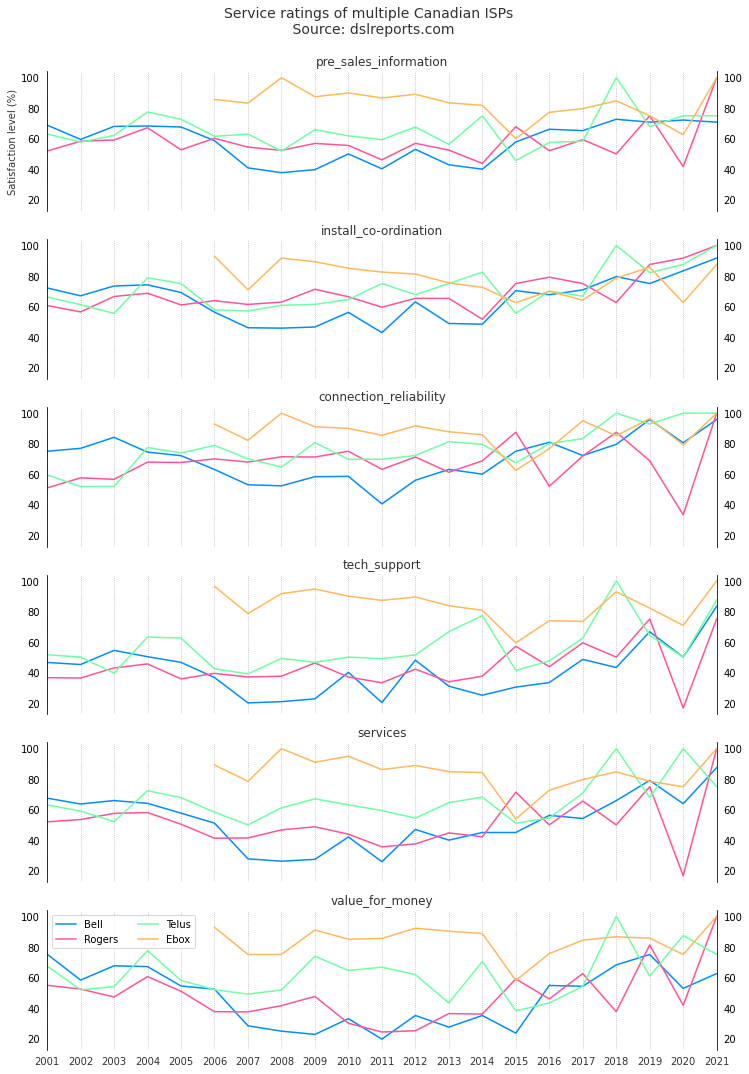

In [17]:
fig, axs = plt.subplots(6, sharex=True, sharey=True, figsize=(12, 18), facecolor='white', frameon=False)

fig.suptitle('Service ratings of multiple Canadian ISPs \n Source: dslreports.com', y=0.93, size=14, alpha=0.8)
for i in range(6):
    axs[i].plot(yearly_ratings_ISP.xs('Bell', level=1).iloc[1:, i], color='#008CFF', label='Bell');
    axs[i].plot(yearly_ratings_ISP.xs('Rogers', level=1).iloc[:, i], color='#FF5396', label='Rogers');
    axs[i].plot(yearly_ratings_ISP.xs('Telus', level=1).iloc[1:, i], color='#6FFFA2', label='Telus');
    axs[i].plot(yearly_ratings_ISP.xs('Ebox', level=1).iloc[:, i], color='#FFB85C', label='Ebox');
    axs[i].set_title(yearly_ratings_ISP.columns[i], alpha=0.8);
    axs[i].tick_params(top=False, bottom=False, left=False, right=False, labelleft=True,labelright=True, labelbottom=False)
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['bottom'].set_visible(False)
    axs[i].margins(x=0)
    axs[i].grid(axis='x', linestyle=':')
    
axs[0].set_ylabel('Satisfaction level (%)', alpha=0.8)

xticks_labels = yearly_ratings_ISP.index.get_level_values(0).unique()[1:]
axs[5].set_xticks(ticks=xticks_labels, labels=xticks_labels, alpha=0.8)
axs[5].tick_params(top=False, bottom=False, left=False, right=False, labelleft=True,labelright=True, labelbottom=True) 
axs[5].spines['bottom'].set_visible(False)
plt.legend(ncol=2)


### Plotting yearly overall ratings of selected Canadian ISPs

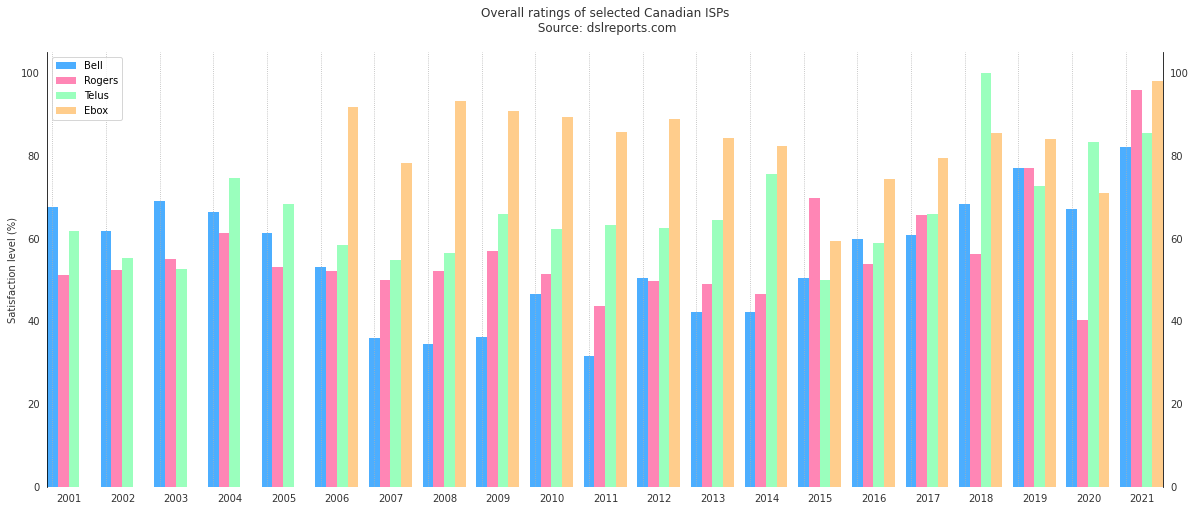

In [18]:
fig = plt.figure(figsize=(20, 8), facecolor='white', frameon=False)

#for isp in yearly_ratings_ISP.index.get_level_values(1).unique():
Bell_df = yearly_ratings_ISP.xs('Bell', level=1).iloc[1:,-1]
plt.bar(Bell_df.index,Bell_df, width=0.2, color='#008CFF', alpha=0.7, label='Bell');

Rogers_df = yearly_ratings_ISP.xs('Rogers', level=1).iloc[:,-1]
plt.bar(Rogers_df.index+.2,Rogers_df, width=0.2, color='#FF5396', alpha=0.7, label='Rogers');

Telus_df = yearly_ratings_ISP.xs('Telus', level=1).iloc[1:,-1]
plt.bar(Telus_df.index+.4,Telus_df, width=0.2, color='#6FFFA2', alpha=0.7, label='Telus');

Ebox_df = yearly_ratings_ISP.xs('Ebox', level=1).iloc[:,-1]
plt.bar(Ebox_df.index+.6, Ebox_df, width=0.2, color='#FFB85C', alpha=0.7, label='Ebox');

plt.title('Overall ratings of selected Canadian ISPs\n Source: dslreports.com', pad= 20, alpha=0.8)

plt.ylabel('Satisfaction level (%)', alpha=0.8)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=True,labelright=True, labelbottom=True)
plt.margins(x=0)
xticks_labels = yearly_ratings_ISP.index.get_level_values(0).unique()[1:]
plt.xticks(ticks=xticks_labels, labels=xticks_labels, alpha=0.8)

# Align labels horizontally to left 
plt.setp( plt.gca().xaxis.get_majorticklabels(), ha="left")
 
# offset the label in horizontal direction 
import matplotlib.transforms
# Create offset transform by 4 points in x direction
dx = 4/72.
dy = 0/72.
offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
# apply offset transform to all x ticklabels.
i=0
for label in plt.gca().xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + offset)
            
plt.yticks(alpha=0.8);
plt.legend()
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.grid(axis='x', linestyle=':')


## 3. Conclusions and future work

#### In this notebook, we used BeautifulSoup to extract review data of multiple Canadian ISPs from dslreports.com and save the resulting dataset to a csv file.

#### We also used matplotlib to generate a couple charts from the extracted data. They show the reviewers' satisfaction levels with major Canadian ISPs for the last two decades.

#### We shied away from any comparative analysis of these ISPs since the sample size is quite small. As you can see in the next cell, the number of reviews posted for all the Canadian ISPs combined on dslreport.com per year is small and has been significantly decreasing during the last few years.

#### However, the aim from this notebook is educational. It is to demonstrate how meaningful data can be extracted from semi-structred data on the web and visualized or saved in a tabular format for future analysis.

#### As a future work and a good charting practice, the extracted data can be used for spatial data visualization. We have the locations of the reviewers along with their ISP ratings. Drawing these ratings on a map can be quite interesting. 

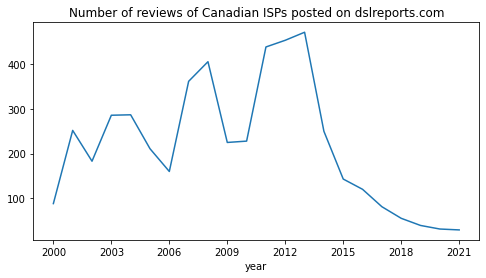

In [19]:
#Number of reviews posted for all the Canadian ISPs combined on dslreport.com each year from 2000 to 2021
num_reviews_per_year = review_data_ISP_df.groupby([review_data_ISP_df.date.dt.year])['ISP_name'].count()
num_reviews_per_year.plot(xlabel='year', 
                          xticks = review_data_ISP_df.date.dt.year.unique()[::3], 
                          title = 'Number of reviews of Canadian ISPs posted on dslreports.com', 
                          figsize=(8,4));